In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [3]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

temp = pd.read_csv('../data/go/go_bp3.csv')
temp.word.fillna('NA', inplace=True)

temp1 = pd.read_csv('../data/go/go_mf3.csv')
temp1.word.fillna('NA', inplace=True)
temp1 = temp1.rename(columns={'encoding' : 'encoding_z'})

data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
data_list = data_list.merge(temp1, on=['article', 'sentence_no', 'word_no'])
data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
x_counts = data_list.encoding_x.value_counts()
y_counts = data_list.encoding_y.value_counts()
z_counts = data_list.encoding_z.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if (i == 'O' and j == 'O') else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
temp_encoding = []
for i,j,k in zip(data_list.encoding_x, data_list.encoding_y, data_list.encoding_z):
    if i == j and j == k:
        temp_encoding.append('O')
    elif i == 'O' and j != 'O':
        temp_encoding.append(j)
    elif j == 'O' and i != 'O':
        temp_encoding.append(i)
    else:
        temp_encoding.append(k)
data_list['encoding'] = temp_encoding
val_cnt = data_list.encoding.value_counts()
data_list['encoding'] = data_list.encoding.apply(lambda x: 'O' if val_cnt[x] < 5 else x)
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [4]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('Gender', 'O', 'NN'), ('does', 'O', 'VBZ'), ('not', 'O', 'RB'), ('typically', 'O', 'RB'), ('affect', 'O', 'JJ'), ('IOP', 'O', 'NNP'), ('and', 'O', 'CC'), ('aging', 'GO:0007568', 'VBG'), ('results', 'O', 'NNS'), ('in', 'O', 'IN'), ('an', 'O', 'DT'), ('IOP', 'O', 'NNP'), ('decrease', 'O', 'NN'), ('in', 'O', 'IN'), ('some', 'O', 'DT'), ('strains', 'O', 'NNS'), ('.', 'O', '.')]
7579
15979
495
44


In [5]:
max_len = 75
max_len_char = 15

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [6]:
print(tag2idx)

{'2_GO:0010628': 1, 'GO:0043005': 264, '2_GO:0048339': 133, 'GO:0007613': 2, 'GO:0006266': 265, 'GO:0016265': 43, '1_GO:0006955': 389, '2_GO:0042633': 266, '2_GO:0000380': 416, '1_GO:0006094': 3, '1_GO:0043234': 460, '2_GO:0006396': 267, '2_GO:0034205': 268, 'GO:1990603': 4, 'GO:0006457': 5, '1_GO:0060216': 269, '2_GO:0006302': 270, '1_GO:0043277': 271, '2_GO:0007281': 6, '2_GO:0012501': 273, 'GO:0000786': 7, '1_GO:0098762': 85, 'GO:0050817': 274, '1_GO:0007631': 316, 'GO:0071514': 275, 'GO:0022008': 277, '1_GO:0000805': 423, '2_GO:0051726': 9, '1_GO:0009887': 10, 'GO:0044317': 348, 'GO:0007126': 11, '1_GO:0007596': 280, '1_GO:0001709': 12, 'GO:0005634': 281, 'GO:0009294': 418, '1_GO:0030168': 13, '1_GO:0051716': 282, '1_GO:0042461': 15, '1_GO:0030509': 283, 'GO:0016458': 16, '2_GO:0001501': 285, '2_GO:0007129': 17, 'GO:0001967': 286, '1_GO:0001654': 287, '2_GO:0043234': 45, '1_GO:0035162': 288, '2_GO:0006006': 18, 'GO:0031649': 289, 'GO:0045120': 19, '1_GO:0060425': 291, '1_GO:0001774

In [7]:
print(pos2idx)

{'WP$': 1, '$': 2, 'TO': 3, 'MD': 4, 'PRP$': 6, 'NNP': 7, 'NNS': 8, 'VBN': 9, 'NNPS': 10, 'UH': 11, 'PRP': 12, 'RBS': 13, '``': 14, 'DT': 15, 'X': 0, '.': 16, 'WP': 5, 'WDT': 17, 'PDT': 20, 'EX': 19, ',': 21, 'VBG': 22, 'SYM': 23, 'VBD': 24, 'RP': 25, 'IN': 26, 'FW': 27, 'RBR': 28, 'VB': 29, ':': 30, 'NN': 31, 'POS': 32, ')': 33, 'VBP': 34, 'CD': 35, 'RB': 36, 'VBZ': 37, 'CC': 18, "''": 38, 'JJS': 39, 'JJ': 40, '#': 41, 'JJR': 42, 'WRB': 43, '(': 44}


In [8]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

128


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [12]:
X_word = [[w[0] for w in s] for s in data_list]
new_X = []
for seq in X_word:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    new_X.append(new_seq)
X_word = new_X

In [13]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [14]:
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [15]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [16]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [17]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel
INFO:tensorflow:Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed
INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry
INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5
INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfh

In [19]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten,Lambda
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

# input and embedding for words
word_in = Input(shape=(max_len,), dtype=tf.string)

emb_word = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)


dropout = Dropout(0.3)(emb_char)

char_enc = TimeDistributed(LSTM(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(dropout)

# main GRU
x = concatenate([emb_word, char_enc, emb_pos])
main_lstm = Bidirectional(LSTM(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, pos_in, char_in], out)

In [20]:
from keras.optimizers import RMSprop
import keras.backend as K

def customLoss(yTrue,yPred):
    return - K.sum(yTrue * K.log(yPred))

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss=customLoss, metrics=["acc"])

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 15)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 15, 100)  13000       input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 75, 15, 100)  0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (I

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/LSTM-Elmo.png')

In [23]:
from keras.callbacks import EarlyStopping

history = model.fit([X_word_tr[:len(X_word_tr)//32*32], X_pos_tr[:len(X_word_tr)//32*32],
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))[:len(X_word_tr)//32*32]],
                    np.array(y_tr[:len(X_word_tr)//32*32]),
                    batch_size=32, epochs=100, validation_data=([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]],
                    np.array(y_te[:len(y_te)//32*32])),
                    verbose=1, callbacks=[EarlyStopping(patience=3)])

Train on 5280 samples, validate on 2272 samples
Epoch 1/100
5280/5280 [==============================] - 100s 19ms/step - loss: 540.1307 - acc: 0.9415 - val_loss: 268.8364 - val_acc: 0.9562
Epoch 2/100
5280/5280 [==============================] - 97s 18ms/step - loss: 229.3271 - acc: 0.9607 - val_loss: 177.4843 - val_acc: 0.9676
Epoch 3/100
5280/5280 [==============================] - 98s 18ms/step - loss: 161.0038 - acc: 0.9685 - val_loss: 140.7418 - val_acc: 0.9734
Epoch 4/100
5280/5280 [==============================] - 98s 18ms/step - loss: 119.2264 - acc: 0.9742 - val_loss: 107.0602 - val_acc: 0.9772
Epoch 5/100
5280/5280 [==============================] - 98s 18ms/step - loss: 91.4220 - acc: 0.9789 - val_loss: 97.7298 - val_acc: 0.9795
Epoch 6/100
5280/5280 [==============================] - 98s 18ms/step - loss: 70.8673 - acc: 0.9823 - val_loss: 87.6052 - val_acc: 0.9812
Epoch 7/100
5280/5280 [==============================] - 98s 18ms/step - loss: 56.0467 - acc: 0.9854 - val_lo

In [24]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_LSTM-Elmo.tsv', sep='\t')

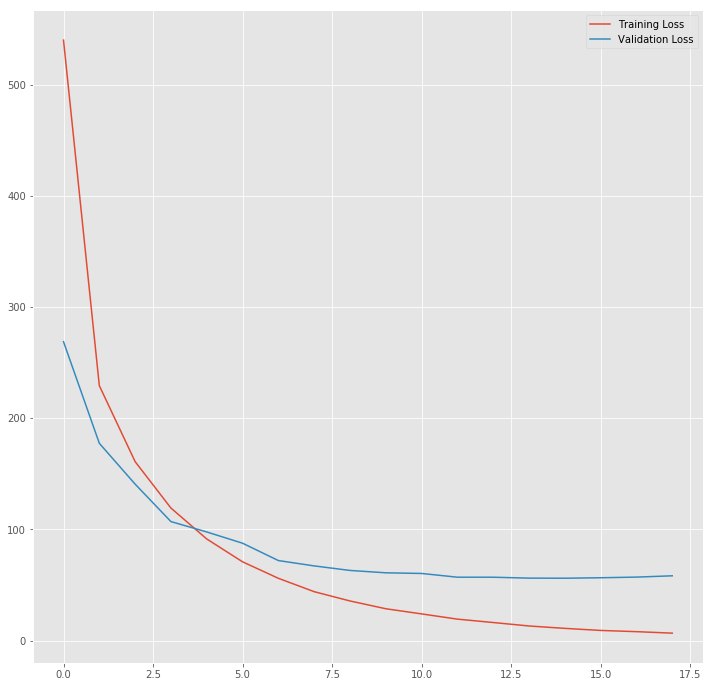

In [25]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

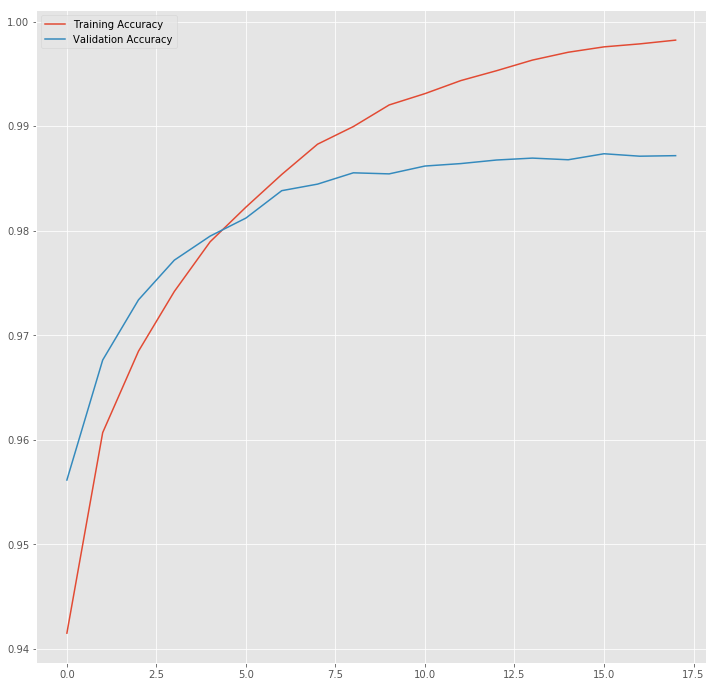

In [26]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                        np.array(X_char_te[:len(y_te)//32*32]).reshape((len(X_char_te[:len(y_te)//32*32]),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: y, y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

1_GO:0000380       0.80      1.00      0.89        12
1_GO:0000725       0.75      1.00      0.86         6
1_GO:0000795       1.00      1.00      1.00         2
1_GO:0000803       0.92      0.92      0.92        12
1_GO:0000805       0.43      1.00      0.60         3
1_GO:0000806       0.86      1.00      0.92         6
1_GO:0001171       1.00      0.83      0.91         6
1_GO:0001501       1.00      0.67      0.80         3
1_GO:0001502       0.00      0.00      0.00         2
1_GO:0001658       0.67      1.00      0.80         2
1_GO:0001739       0.95      1.00      0.97        19
1_GO:0001741       0.87      1.00      0.93        27
1_GO:0001750       0.96      1.00      0.98        23
1_GO:0001755       0.00      0.00      0.00         1
1_GO:0001763       0.67      1.00      0.80         2
1_GO:0001764       0.00      0.00      0.00         1
1_GO:0001774       0.00      0.00      0.00         2
1_GO:0001775       0.00    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [29]:
df = df[df['Word'] != 'O']

In [30]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



              precision    recall  f1-score   support

1_GO:0000380       0.80      1.00      0.89        12
1_GO:0000725       0.75      1.00      0.86         6
1_GO:0000795       1.00      1.00      1.00         2
1_GO:0000803       0.92      0.92      0.92        12
1_GO:0000805       0.43      1.00      0.60         3
1_GO:0000806       0.86      1.00      0.92         6
1_GO:0001171       1.00      0.83      0.91         6
1_GO:0001501       1.00      0.67      0.80         3
1_GO:0001502       0.00      0.00      0.00         2
1_GO:0001658       0.67      1.00      0.80         2
1_GO:0001739       0.95      1.00      0.97        19
1_GO:0001741       0.87      1.00      0.93        27
1_GO:0001750       0.96      1.00      0.98        23
1_GO:0001755       0.00      0.00      0.00         1
1_GO:0001763       0.67      1.00      0.80         2
1_GO:0001764       0.00      0.00      0.00         1
1_GO:0001774       0.00      0.00      0.00         2
1_GO:0001775       0.00  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [31]:
# df.to_csv('../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv', sep='\t')

In [32]:
# !python ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 
#%run ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 